In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

seismic_data_filename = "data_pt1/F3_train.npy"
seismic_attr_cosine_instantaneous_phase_filename = "data_pt1/F3_train_cosine_instantaneous_phase.npy"

def filter_data(data): return data[0:2,0:5,0:5]

# Read the seismic data samples from a NPY file
seismic_data   = filter_data(np.load(seismic_data_filename))
seismic_cos_inst_phase = filter_data(np.load(seismic_attr_cosine_instantaneous_phase_filename))

# Dataset size
N_INLINES = len(seismic_data[:,0,0])
N_TRACES = len(seismic_data[0,:,0])
N_TRACE_SAMPLES = len(seismic_data[0,0,:])

# Dataset split size
TRAIN_SET_PERCENTAGE = 0.8

In [119]:
c = 0
x = np.arange(1, 28)
x = np.reshape(x, (3,3,3))
x1 = np.copy(x)
neighbors = np.copy(x).reshape((1, np.size(x)))
for i in range(c):
    x1[:,:,0] = 0
    x1 = np.roll(x1, -1, axis=2)
    print(x1)
    neighbors = np.append(neighbors, np.reshape(x1, (1, np.size(x1))), axis=0)
print(x)

neighbors

[[[ 1  2  3]
  [ 4  5  6]
  [ 7  8  9]]

 [[10 11 12]
  [13 14 15]
  [16 17 18]]

 [[19 20 21]
  [22 23 24]
  [25 26 27]]]


array([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]])

In [67]:
x = np.arange(27)
x = np.reshape(x, (3,3,3))
x


array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

In [68]:
x1 = np.copy(x)
x1[:,2,:] = 0
x1

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 0,  0,  0]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [ 0,  0,  0]],

       [[18, 19, 20],
        [21, 22, 23],
        [ 0,  0,  0]]])

In [69]:
x1 = np.roll(x1, 1, axis=1)
x1

array([[[ 0,  0,  0],
        [ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 0,  0,  0],
        [ 9, 10, 11],
        [12, 13, 14]],

       [[ 0,  0,  0],
        [18, 19, 20],
        [21, 22, 23]]])

In [92]:
y = np.arange(9).reshape(1,9)
y1 = np.arange(9,18).reshape(1,9)
y = np.append(y,y1,axis=0)
y

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
       [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [89]:
z = np.arange(8).reshape(1,8)

z

array([[0, 1, 2, 3, 4, 5, 6, 7]])

## Function for getting the neighbors from a sample

In [4]:
# Get a subarray of the index neighbors
# :param sides
#      -1: get only the previous neighbors
#       0: get both previous and next neighbors
#       1: get only the next neighbors
def getNeighbors(data, index, n_Neighbors, sides=0):
    size = n_Neighbors * 2 if sides == 0 else n_Neighbors
    neighbors = np.zeros(size + 1)
    
    start = n_Neighbors if sides < 1 else 0

    neighbors[start] = data[index]
    for i in range(1, n_Neighbors+1):
        if (index + i < len(data) and sides > -1):
            neighbors[start + i] = data[index + i]
        if (index - i > 0 and sides < 1):
            neighbors[start - i] = data[index - i]

    return neighbors


## Linear Regression with no feature extraction

### Training model

In [3]:
# Splitting dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(seismic_data, seismic_cos_inst_phase, test_size=1-TRAIN_SET_PERCENTAGE)

n_train_inlines = len(X_train[:,0,0])
n_train_traces = len(X_train[0,:,0])
n_train_samples = len(X_train[0,0,:])

N_NEIGHBORS = 1

# Creating the model
model = LinearRegression()

# Transforming data into features
train_set = np.empty([np.size(X_train), N_NEIGHBORS*2+1])
c = 0
for i in range(n_train_inlines):
    for j in range(n_train_traces):
        for k in range(n_train_samples):

            train_set[c] = getNeighbors(X_train[i,j,:], k, N_NEIGHBORS)
            c += 1

model.fit(train_set, np.reshape(y_train[:,:,:], np.size(y_train)))

LinearRegression()

### Making Prediction and calculating erros

In [4]:
n_test_inlines = len(X_test[:,0,0])
n_test_traces = len(X_test[0,:,0])
n_test_samples = len(X_test[0,0,:])

# Transforming test dataset to make predictions
test_set = np.empty([np.size(X_test), N_NEIGHBORS*2+1])
c = 0
for i in range(n_test_inlines):
    for j in range(n_test_traces):
        for k in range(n_test_samples):
            test_set[c] = getNeighbors(X_test[i,j,:], k, N_NEIGHBORS)
            c += 1

# Train MSE
y_hat = model.predict(train_set)
MSE = mean_squared_error(np.reshape(y_train[:,:,:], np.size(y_train)), y_hat)
print("MSE train:", MSE)

# Test MSE
y_hat = model.predict(test_set)
MSE = mean_squared_error(np.reshape(y_test[:,:,:], np.size(y_test)), y_hat)
print("MSE test:", MSE)


MSE train: 0.18776240639006603
MSE test: 0.18764479190382533


## Polynomial Regression

### Training model

In [4]:
# Splitting dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(seismic_data, seismic_cos_inst_phase, test_size=1-TRAIN_SET_PERCENTAGE)

n_train_inlines = len(X_train[:,0,0])
n_train_traces = len(X_train[0,:,0])
n_train_samples = len(X_train[0,0,:])

N_NEIGHBORS = 1

# Creating the model
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
linear_regression = LinearRegression()

poly2_model = Pipeline(
    [
        ("polynomial_features", polynomial_features),
        ("linear_regression", linear_regression),
    ]
)


# Transforming data into features
train_set = np.empty([np.size(X_train), N_NEIGHBORS+1])
c = 0
for i in range(n_train_inlines):
    for j in range(n_train_traces):
        for k in range(n_train_samples):
            train_set[c] = getNeighbors(X_train[i,j,:], k, N_NEIGHBORS, sides=1)
            c += 1

poly2_model.fit(train_set, np.reshape(y_train[:,:,:], np.size(y_train)))

KeyboardInterrupt: 

### Making Prediction and calculating erros

In [4]:
n_test_inlines = len(X_test[:,0,0])
n_test_traces = len(X_test[0,:,0])
n_test_samples = len(X_test[0,0,:])

# Transforming test dataset to make predictions
test_set = np.empty([np.size(X_test), N_NEIGHBORS+1])
c = 0
for i in range(n_test_inlines):
    for j in range(n_test_traces):
        for k in range(n_test_samples):
            test_set[c] = getNeighbors(X_test[i,j,:], k, N_NEIGHBORS, sides=1)
            c += 1

# Train MSE
y_hat = poly2_model.predict(train_set)
MSE = mean_squared_error(np.reshape(y_train[:,:,:], np.size(y_train)), y_hat)
print("MSE train:", MSE)

# Test MSE
y_hat = poly2_model.predict(test_set)
MSE = mean_squared_error(np.reshape(y_test[:,:,:], np.size(y_test)), y_hat)
print("MSE test:", MSE)


MSE train: 0.1218836331053552
MSE test: 0.12078359865518351


## Feature extraction with neighbors mean

### Training model

In [4]:
# Splitting dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(seismic_data, seismic_cos_inst_phase, test_size=1-TRAIN_SET_PERCENTAGE)

n_train_inlines = len(X_train[:,0,0])
n_train_traces = len(X_train[0,:,0])
n_train_samples = len(X_train[0,0,:])

N_NEIGHBORS = 1

# Creating the model
LRModel = LinearRegression()


# Transforming data into features
train_set = np.empty([np.size(X_train), 2])
c = 0
for i in range(n_train_inlines):
    for j in range(n_train_traces):
        for k in range(n_train_samples):
            train_set[c] = [X_train[i,j,k], np.mean(np.delete(getNeighbors(X_train[i,j,:], k, N_NEIGHBORS, sides=0), N_NEIGHBORS))]
            c += 1

LRModel.fit(train_set, np.reshape(y_train[:,:,:], np.size(y_train)))

LinearRegression()

### Making Prediction and calculating erros

In [5]:
n_test_inlines = len(X_test[:,0,0])
n_test_traces = len(X_test[0,:,0])
n_test_samples = len(X_test[0,0,:])

# Transforming test dataset to make predictions
test_set = np.empty([np.size(X_test), 2])
c = 0
for i in range(n_test_inlines):
    for j in range(n_test_traces):
        for k in range(n_test_samples):
            test_set[c] = [X_test[i,j,k], np.mean(np.delete(getNeighbors(X_test[i,j,:], k, N_NEIGHBORS, sides=0), N_NEIGHBORS))]
            c += 1

# Train MSE
y_hat = LRModel.predict(train_set)
MSE = mean_squared_error(np.reshape(y_train[:,:,:], np.size(y_train)), y_hat)
MAE = mean_absolute_error(np.reshape(y_train[:,:,:], np.size(y_train)), y_hat)
R2 = r2_score(np.reshape(y_train[:,:,:], np.size(y_train)), y_hat)
print("MSE train:", MSE)
print("MAE train:", MAE)
print("R2 train:", R2)

# Test MSE
y_hat = LRModel.predict(test_set)
MSE = mean_squared_error(np.reshape(y_test[:,:,:], np.size(y_test)), y_hat)
MAE = mean_absolute_error(np.reshape(y_test[:,:,:], np.size(y_test)), y_hat)
R2 = r2_score(np.reshape(y_test[:,:,:], np.size(y_test)), y_hat)
print("MSE test:", MSE)
print("MAE test:", MAE)
print("R2 test:", R2)


MSE train: 0.19336055890329182
MAE train: 0.349787648475717
R2 train: 0.6084282678359698
MSE test: 0.19340022406300814
MAE test: 0.34974250229572657
R2 test: 0.608499162009959


## Random Forest

### Training model

In [5]:
# Splitting dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(seismic_data, seismic_cos_inst_phase, test_size=1-TRAIN_SET_PERCENTAGE)

n_train_inlines = len(X_train[:,0,0])
n_train_traces = len(X_train[0,:,0])
n_train_samples = len(X_train[0,0,:])

N_NEIGHBORS = 1

# Creating the model
RFRegressor = RandomForestRegressor(n_estimators=10, random_state=0)

# Transforming data into features
train_set = np.empty([np.size(X_train), N_NEIGHBORS*2+1])
c = 0
for i in range(n_train_inlines):
    for j in range(n_train_traces):
        for k in range(n_train_samples):
            train_set[c] = getNeighbors(X_train[i,j,:], k, N_NEIGHBORS)
            c += 1

RFRegressor.fit(train_set, np.reshape(y_train[:,:,:], np.size(y_train)))

: 

: 

### Making Prediction and calculating erros

In [ ]:
n_test_inlines = len(X_test[:,0,0])
n_test_traces = len(X_test[0,:,0])
n_test_samples = len(X_test[0,0,:])

# Transforming test dataset to make predictions
test_set = np.empty([np.size(X_test), N_NEIGHBORS*2+1])
c = 0
for i in range(n_test_inlines):
    for j in range(n_test_traces):
        for k in range(n_test_samples):
            test_set[c] = getNeighbors(X_test[i,j,:], k, N_NEIGHBORS)
            c += 1

# Train MSE
y_hat = RFRegressor.predict(train_set)
MSE = mean_squared_error(np.reshape(y_train[:,:,:], np.size(y_train)), y_hat)
print("MSE train:", MSE)

# Test MSE
y_hat = RFRegressor.predict(test_set)
MSE = mean_squared_error(np.reshape(y_test[:,:,:], np.size(y_test)), y_hat)
print("MSE test:", MSE)


MSE train: 16.207284369595694
MSE test: 91.16826017619087


## Visualizing results

In [5]:
# Transforming data for visualization
c = 0
show_panel = np.empty([n_test_inlines, n_test_traces, n_test_samples])
for i in range(n_test_inlines):
    for j in range(n_test_traces):
        for k in range(n_test_samples):
            show_panel[i,j,k] = y_hat[c]
            c+=1

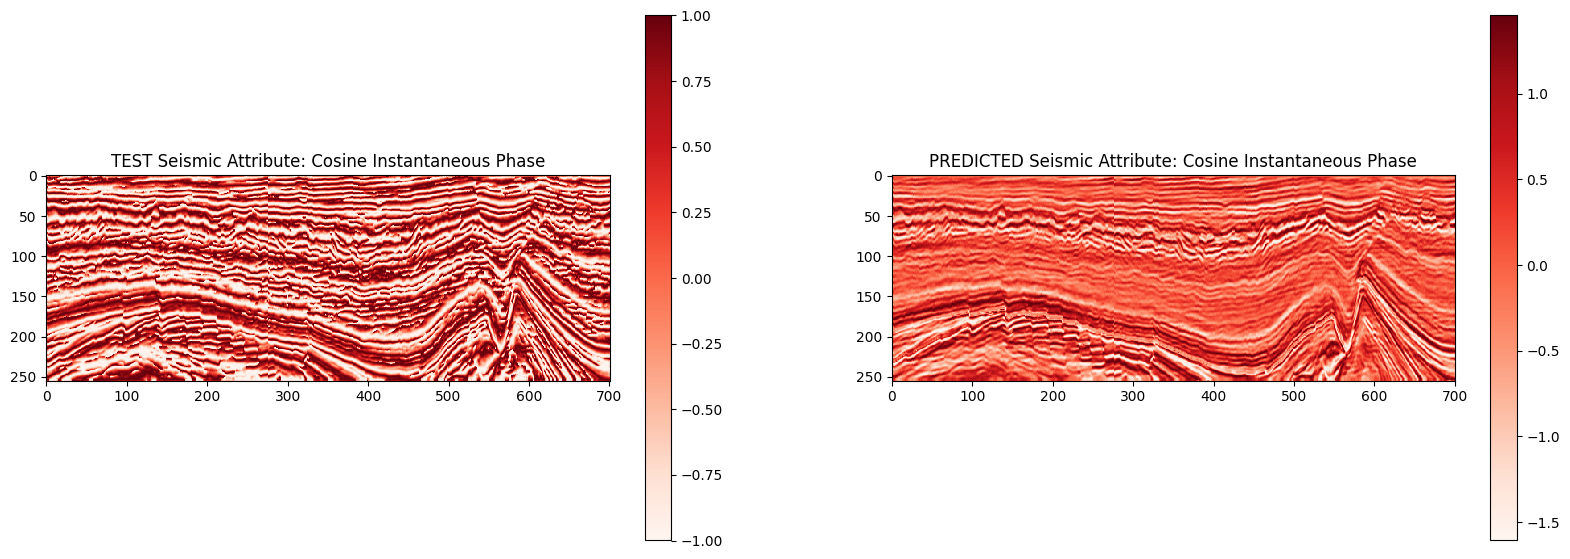

In [6]:
# Comparing the predicted vs real data
f, axarr = plt.subplots(2,2, sharex = False,sharey=False)
f.set_size_inches(20,15)

ax = axarr[0][0]
panel = y_test[0,:,:].T # Transposing the data to make visualization more natural
vmax = vmax = np.abs(panel).max()
vmin = -vmax
subfig = ax.imshow(panel,vmax=vmax, vmin=vmin, cmap="Reds", interpolation='nearest')
ax.title.set_text("TEST Seismic Attribute: Cosine Instantaneous Phase")
f.colorbar(subfig, ax=ax)

# Plot the Cosine Instantaneous Phase seismic attribute
ax = axarr[0][1]
panel = show_panel[0,:,:].T # Transposing the data to make visualization more natural
subfig = ax.imshow(panel, cmap="Reds", interpolation='nearest')
ax.title.set_text("PREDICTED Seismic Attribute: Cosine Instantaneous Phase")
f.colorbar(subfig, ax=ax)

# Remove empty subplot
f.delaxes(axarr[1][0])
f.delaxes(axarr[1][1])